In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/rand2/GxC.txt", anno_dir = "./data/symsim2/rand2/cell_label1.txt")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/rand2/RxC.txt", anno_dir = "./data/symsim2/rand2/cell_label2.txt")

In [9]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_atac_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

In [10]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [11]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(rna_CONFIG)), 
        ("decoder", ae.Decoder(rna_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(atac_CONFIG)), 
        ("decoder", ae.Decoder(atac_CONFIG))
      ])).to(device)


optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-4)

In [12]:
pre_train_ae(model = ae1, data_loader = train_rna_loader, diff_sim = Diff1, optimizer = optimizer_rna, P = U_t1, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.34520, recon loss: 0.00000, dist loss: 0.34520
epoch:  10 Total loss: 0.17895, recon loss: 0.00000, dist loss: 0.17895
epoch:  20 Total loss: 0.15907, recon loss: 0.00000, dist loss: 0.15907
epoch:  30 Total loss: 0.13947, recon loss: 0.00000, dist loss: 0.13947
epoch:  40 Total loss: 0.14734, recon loss: 0.00000, dist loss: 0.14734
epoch:  50 Total loss: 0.18088, recon loss: 0.00000, dist loss: 0.18088
epoch:  60 Total loss: 0.16186, recon loss: 0.00000, dist loss: 0.16186
epoch:  70 Total loss: 0.16918, recon loss: 0.00000, dist loss: 0.16918


KeyboardInterrupt: 

In [ ]:
pre_train_ae(model = ae2, data_loader = train_atac_loader, diff_sim = Diff2, optimizer = optimizer_atac, P = U_t2, n_epochs = 201, lambda_r = 0, dist_mode = "mse")

In [ ]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [9]:
disc = ae.discriminator(hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [10]:
pre_train_disc(model_rna = ae1, model_atac = ae2, disc = disc, data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, optimizer_D = optimizer_D, n_epochs = 201, use_anchor = False)

epoch:  0 Discriminator loss: 0.69311
epoch:  10 Discriminator loss: 0.68736
epoch:  20 Discriminator loss: 0.68373
epoch:  30 Discriminator loss: 0.68087
epoch:  40 Discriminator loss: 0.67854
epoch:  50 Discriminator loss: 0.67583
epoch:  60 Discriminator loss: 0.67345
epoch:  70 Discriminator loss: 0.67010
epoch:  80 Discriminator loss: 0.66651
epoch:  90 Discriminator loss: 0.66353
epoch:  100 Discriminator loss: 0.65839
epoch:  110 Discriminator loss: 0.65460
epoch:  120 Discriminator loss: 0.64915
epoch:  130 Discriminator loss: 0.64483
epoch:  140 Discriminator loss: 0.63845
epoch:  150 Discriminator loss: 0.63212
epoch:  160 Discriminator loss: 0.62789
epoch:  170 Discriminator loss: 0.61850
epoch:  180 Discriminator loss: 0.61274
epoch:  190 Discriminator loss: 0.60701
epoch:  200 Discriminator loss: 0.60570


In [11]:
# n_iter = 200 merge too good
train_unpaired(ae1, ae2, disc, train_rna_loader, train_atac_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=201, n_iter=200, n_iter2 = 1, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA loss: 0.13906, RNA recon loss: 0.00000, RNA dist loss: 0.13906 ATAC loss: 0.15953, ATAC recon loss: 0.00000, ATAC dist loss: 0.15953 Discriminator loss: 0.72189
epoch:  10 RNA loss: 0.24624, RNA recon loss: 0.00000, RNA dist loss: 0.24624 ATAC loss: 0.20490, ATAC recon loss: 0.00000, ATAC dist loss: 0.20490 Discriminator loss: 0.42329
epoch:  20 RNA loss: 0.18511, RNA recon loss: 0.00000, RNA dist loss: 0.18511 ATAC loss: 0.24067, ATAC recon loss: 0.00000, ATAC dist loss: 0.24067 Discriminator loss: 0.65276
epoch:  30 RNA loss: 0.21482, RNA recon loss: 0.00000, RNA dist loss: 0.21482 ATAC loss: 0.21712, ATAC recon loss: 0.00000, ATAC dist loss: 0.21712 Discriminator loss: 0.51541
epoch:  40 RNA loss: 0.21141, RNA recon loss: 0.00000, RNA dist loss: 0.21141 ATAC loss: 0.22936, ATAC recon loss: 0.00000, ATAC dist loss: 0.22936 Discriminator loss: 0.59904
epoch:  50 RNA loss: 0.22586, RNA recon loss: 0.00000, RNA dist loss: 0.22586 ATAC loss: 0.22513, ATAC recon loss: 0.0000

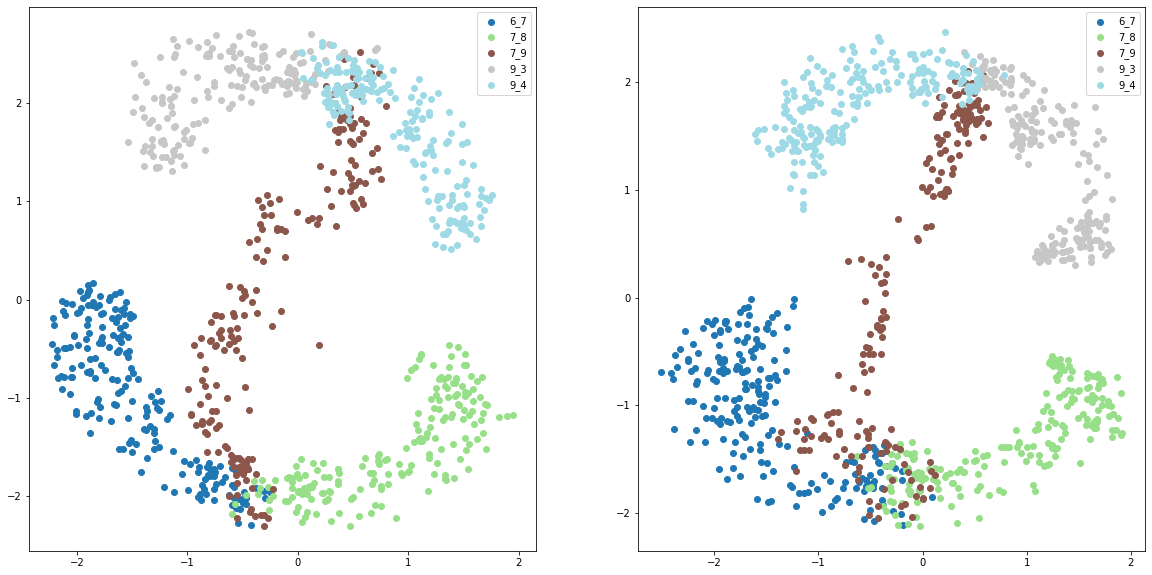

In [12]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_rna_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_atac_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

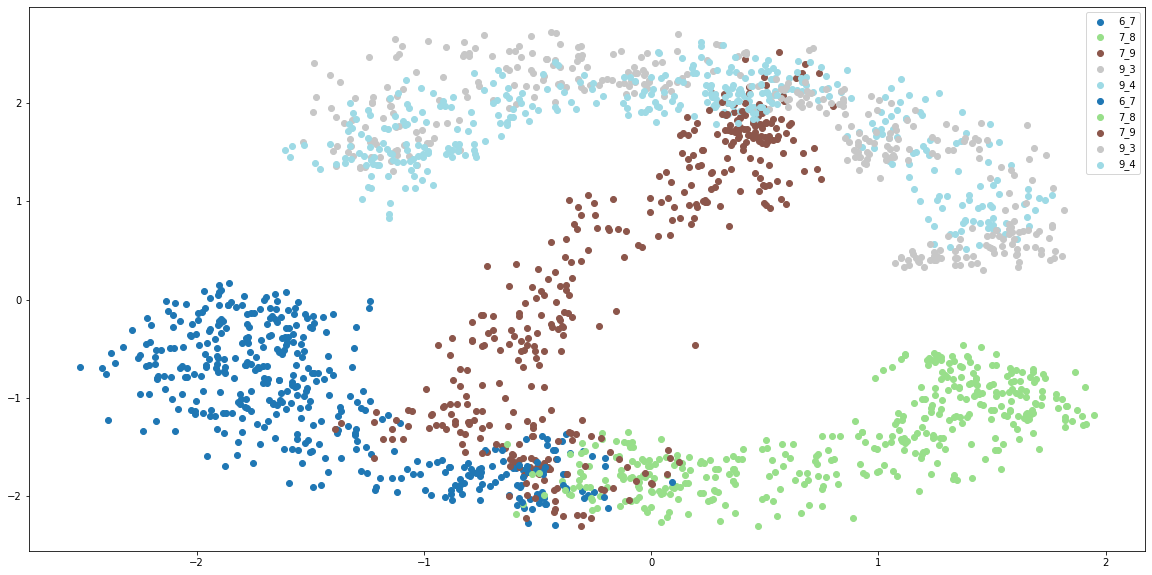

In [13]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)